# 4H-JENA CONTROS pCO2 Algorithm for QuinCe
This notebook is the "definitive" version of the CONTROS algorithm used in QuinCe, developed from work done by:
- Nadja Kinski (4H-JENA)
- Vlad Macovei (Hereon)
- Guiliano Castelli (ISMAR)

## Python Setup
Load libraries required libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'

## Calibration Information
For correct calibration of data, the sensor must be calibration before and after deployment, and information from the calibration sheets is required in the calculations. The required values are:

| Value | From pre-calibration | From post-calibration |
| :-: | :-: | :-: |
| $$F$$ | ✔️ |  |
| $$p_{0}$$ | ✔️ |  |
| $$T_{0}$$ | ✔️ |  |
| $$Runtime$$ | ✔️ | ✔️ |
| $$k_{1}$$ | ✔️ | ✔️ |
| $$k_{2}$$ | ✔️ | ✔️ |
| $$k_{3}$$ | ✔️ | ✔️ |


**Note:** $p_{0}$ and $T_{0}$ are usually the 'standard' expected defaults for surface pressure (1013.25 hPa) and 273.15°K respectively, but this will not always be the case. Be sure to check the calibration sheets every time.

In [2]:
FILE = 'input_file.csv'

F = 61279
p0 = 1013.25 # should be the same as on the Data Processing Sheet
T0 = 273.15  # should be the same as on the Data Processing Sheet

# calibration coefficients from calibration sheets
runtime_pre  = 97335 
k1_pre = 6.145946e-02
k2_pre = 3.103593e-06
k3_pre = 3.546593e-10

runtime_post = 1468557
k1_post = 6.050551e-02
k2_post = 3.729867e-06
k3_post = 2.945140e-10


## Read in data
Read in the data file.

In [3]:
data = pd.read_csv(FILE, sep=',', header=0)

## Calculate S_2beam
The dual-beam NDIR detector provides a raw and a reference signal, $𝑆_{raw}$ and $𝑆_{ref}$ , that are combined to a continuously referenced two-beam signal through 
$$𝑆_{2beam}=\frac{𝑆_{raw}}{𝑆_{ref}}$$

In [4]:
data['S_2beam'] = data['Signal_raw'] / data['Signal_ref']

## Zeroing periods
The sensor periodically runs a zeroing procedure for internal calibration. The results of the zeroing are used in the calculations.

Each zeroing consists of a group of consecutive measurements that will be averaged before being applied as calibration, identified by the `Zero` column in the data being set to `1`. These values are plotted below.

The individual measurements should be QCed by the user and outliers removed - as we see from the plot below, such outliers can be quite common.

No QCing will be performed in this notebook.

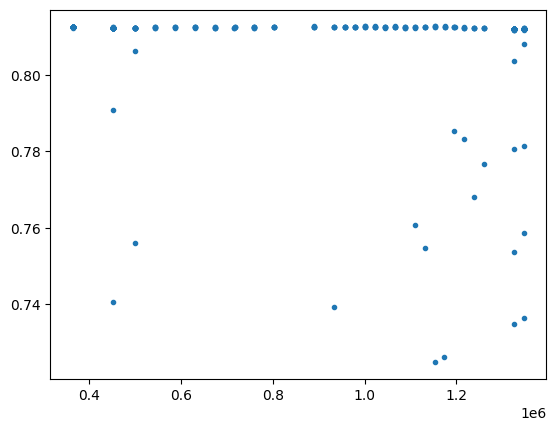

In [5]:
zero_measurements = data[(data['Zero'] == 1) & (data['Flush'] == 0)]
plt.scatter(zero_measurements['Runtime'], zero_measurements['S_2beam'], marker=".")

## Group Zeros
We collect consecutive Zero measurements into groups and average them.

Values QCed out by the user will be removed from their group prior to averaging.

In [6]:
zero_groups = pd.DataFrame(columns=['FirstRuntime', 'LastRuntime', 'MeanRuntime', 'Mean_S2beam'])

prev_index = -100
current_start = None
current_end = None
entries = []
runtimes = []

for index, row in zero_measurements.iterrows():
    if index - prev_index > 1:
        # New zeroing period
        if len(entries) > 0:
            new_row = pd.DataFrame([[current_start, current_end,
                                     np.mean(runtimes), np.mean(entries)]], columns=zero_groups.columns)
            zero_groups = pd.concat([zero_groups, new_row], ignore_index=True)
 
        current_start = row['Runtime']
        current_end = None
        entries = []
        runtimes = []

    entries.append(row['S_2beam'])
    runtimes.append(row['Runtime'])
    current_end = row['Runtime']
    prev_index = index

if len(entries) > 0:
    new_row = pd.DataFrame([[current_start, current_end,
                             np.mean(runtimes), np.mean(entries)]], columns=zero_groups.columns)
    zero_groups = pd.concat([zero_groups, new_row], ignore_index=True)

zero_groups

,FirstRuntime,LastRuntime,MeanRuntime,Mean_S2beam
0,365744,366014,3.658790e+05,0.812475
1,452122,452412,4.522670e+05,0.809185
2,500938,501198,5.010180e+05,0.807117
3,544158,544398,5.442780e+05,0.812365
4,587358,587538,5.874480e+05,0.812420
5,630554,630794,6.306740e+05,0.812415
6,673763,674003,6.738830e+05,0.812350
7,716963,717203,7.170830e+05,0.812358
8,760163,760423,7.602797e+05,0.812378
9,803383,803623,8.035030e+05,0.812457


## Zero Interpolation
The zero calibrations are linearly interpolated across the measurements between them. In the code below the interpolated values are stored in `Zero_Interp`, while in formulae we shall refer to the value as $S_{2beam,Z}$.

In [7]:
# Calculate the interpolated zero point for each data point
zero_interp = []

for index, row in data.iterrows():
    if row['Zero'] == 0 and row['Flush'] == 0:
        zero_before = zero_groups[zero_groups['MeanRuntime'] < row['Runtime']]
        if len(zero_before) == 0:
            #print(f'No prior zero for row {index}')
            zero_before = None
        else:
            zero_before = zero_before.iloc[-1]

        zero_after = zero_groups[zero_groups['MeanRuntime'] > row['Runtime']]
        if len(zero_after) == 0:
            #print(f'No post zero for row {index}')
            zero_after = None
        else:
            zero_after = zero_after.iloc[0]

        if zero_before is None and zero_after is None:
            zero_interp.append(np.nan)
        elif zero_before is None or zero_after is None:
            fixed_zero = zero_after if zero_before is None else zero_before
            zero_interp.append(fixed_zero['Mean_S2beam'])
        else:
            x0 = zero_before['MeanRuntime']
            x1 = zero_after['MeanRuntime']
            y0 = zero_before['Mean_S2beam']
            y1 = zero_after['Mean_S2beam']

            x = row['Runtime']

            zero_interp.append( ((y0 * (x1 - x)) + (y1 * (x - x0))) / (x1 - x0) )
    else:
        zero_interp.append(np.nan)
            

data['Zero_Interp'] = zero_interp

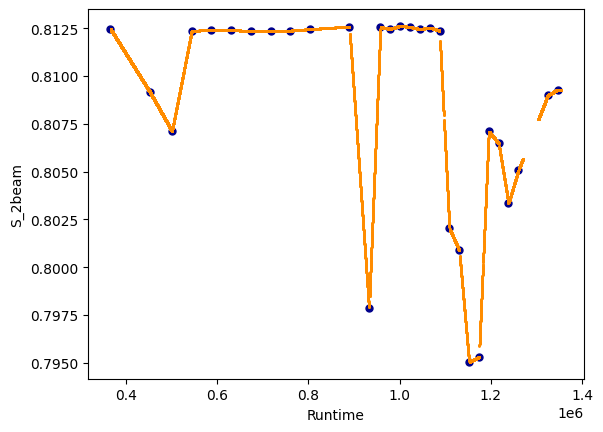

In [8]:
# Plot the interpolated zeros
fig, ax1 = plt.subplots()
ax1.set_xlabel('Runtime') 
ax1.set_ylabel('S_2beam')
ax1.plot(zero_groups['MeanRuntime'], zero_groups['Mean_S2beam'], color='darkblue', marker=".", markersize=10, linewidth=0)
ax1.plot(data['Runtime'], data['Zero_Interp'], color='darkorange', marker=".", markersize=2, linewidth=0)


## Calculate S_DC and S_proc
The drift-corrected signal ($S_{proc}$) can now be calculated using the interpolated zeroing values. For simplicity we do this in two steps:

$$S_{proc}=F\times\left(1−\left(\frac{S_{2beam}}{S_{2beam,Z}}\right)\right)$$

For simplicity and ease of debugging, the code is split into two steps:

$$S_{DC} = \frac{S_{2beam}}{S_{2beam,Z}}$$
$$S_{proc}=F\times\left(1−S_{DC}\right)$$


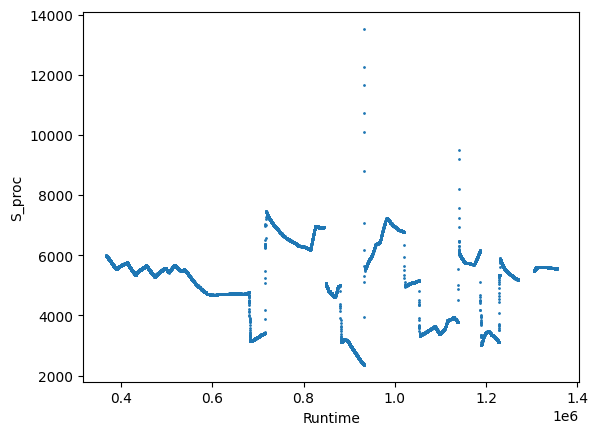

In [9]:
data['S_DC'] = data['S_2beam'] / data['Zero_Interp']
data['S_proc'] = F * (1 - data['S_DC'])

fig, ax1 = plt.subplots()
ax1.set_xlabel('Runtime') 
ax1.set_ylabel('S_proc')
ax1.plot(data['Runtime'], data['S_proc'], marker=".", markersize=2, linewidth=0)


## Calculate xCO₂ and pCO₂
Finally we calculate xCO₂:

$$xCO_{2} = \left( k_3\times S_{proc}^3+ k_2\times S_{proc}^2+ k_1\times S_{proc} \right)\times \frac{p_0\times T}{T_0\times p}$$
where $T$ is the gas temperature (`T_gas` in the data file), $p$ is the pressure in the IR cell (`p_NDIR`), and $p_0$ and $T_0$ are from the calibration as described above.

and pCO₂:

$$pCO_{2} = xCO_{2}\times \frac{p}{p_{0}}$$

**However**, we must interpolate the `k` parameters to calculate the correct drift between the pre- and post-calibration at the point of each measurement. This is simply a case of interpolating each `k` parameter to the `Runtime` value of the measurement. Below we calculate the average change in each `k` value per `Runtime` step, and apply that to the value of each measurement's `Runtime` offset from the pre-calibration `Runtime`.

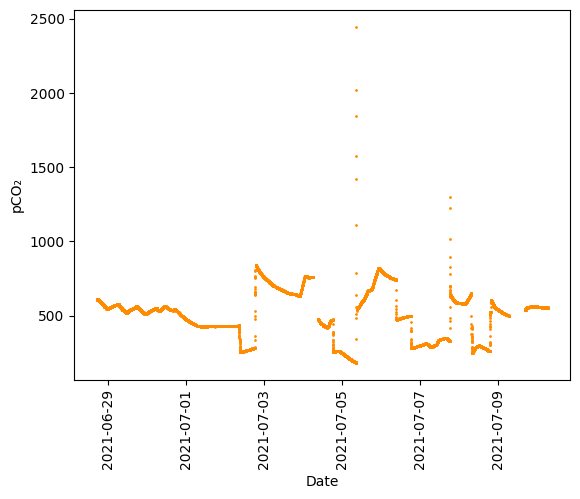

In [12]:
# Change in the k parameters per runtime unit
runtime_calibration_period = runtime_post - runtime_pre
k1_step = (k1_post - k1_pre) / runtime_calibration_period
k2_step = (k2_post - k2_pre) / runtime_calibration_period
k3_step = (k3_post - k3_pre) / runtime_calibration_period

data['xCO2_pp'] = (
    ((k3_pre + (k3_step * data['Runtime'])) * data['S_proc'] ** 3
    + (k2_pre + (k2_step * data['Runtime'])) * data['S_proc'] ** 2
    + (k1_pre + (k1_step * data['Runtime'])) * data['S_proc'] ** 1)
    * ((p0 * (data['T_gas'] + 273.15)) / (T0 * data['p_NDIR'])))

data['pCO2_pp'] = data['xCO2_pp'] * data['p_in'] / p0

# Finally, filter out the zero and flushing values to get the final output dataset
final_data = data.loc[(data['Zero'] == 0) & (data['Flush'] == 0)]
final_data['Timestamp'] = final_data[['Date', 'Time']].apply(lambda x: pd.to_datetime(' '.join(x), format="%d-%m-%Y %H:%M:%S"), axis=1)

# A final plot of the pCO₂
fig, ax1 = plt.subplots()
ax1.set_xlabel('Date') 
ax1.set_ylabel('pCO₂')
ax1.plot(final_data['Timestamp'], final_data['pCO2_pp'], color='darkorange', marker=".", markersize=2, linewidth=0)
plt.setp(ax1.get_xticklabels(), rotation=90)
None